### Base Import for Required Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import time

### Reading Input Data

In [2]:
df = pd.read_csv("/work/phishing_urls.csv")

### 1. Preprocessing
---
**Encoding categorical columns**
For simplicity, we'll use label encoding for categorical columns like 'FILENAME', 'Domain', 'TLD', and 'Title'


In [3]:
encoder = LabelEncoder()
df['FILENAME'] = encoder.fit_transform(df['FILENAME'])
df['Domain'] = encoder.fit_transform(df['Domain'])
df['TLD'] = encoder.fit_transform(df['TLD'])
df['Title'] = encoder.fit_transform(df['Title'])

### 2. Defining Features and Target

In [4]:
X = df.drop(columns=['label', 'URL'])  # Features
y = df['label']  # Target

### 3. Test - Train Split

---
We will use 80:20 ration for Training and Testing proportionate

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Creating Decision Tree Model

In [6]:
model = DecisionTreeClassifier(random_state=42)

### 5. Defining the hyperparameters to tune

In [7]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

### 6. Appling GridSearchCV to evaluate on hyperparameters

In [8]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Record start time
start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Record end time and calculate the time taken
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GridSearchCV completed in: {elapsed_time:.2f} seconds")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END criterion=gini, max_depth=3, min_samples_le

### 7. Get the best parameters and best model

In [9]:
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
# Evaluate the best model
best_model = grid_search.best_estimator_

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 8. Predict using the best model

In [10]:
y_pred = best_model.predict(X_test)

### 9. Evaluation

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



## Plotting of Various Types of Charts for Best Model

### 1. Plotting Confusion Matrix

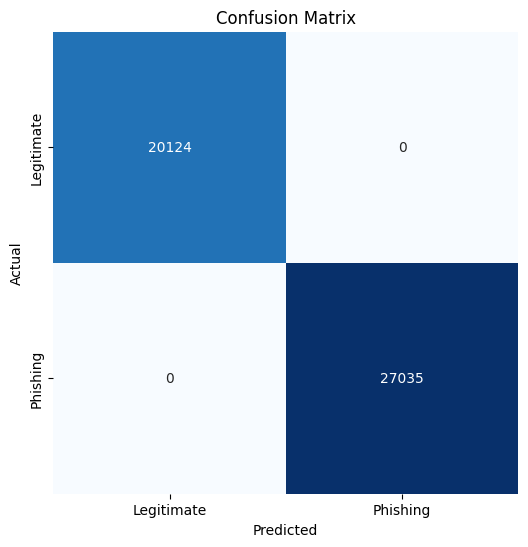

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Legitimate', 'Phishing'], 
            yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 2. Plotting ROC Curve

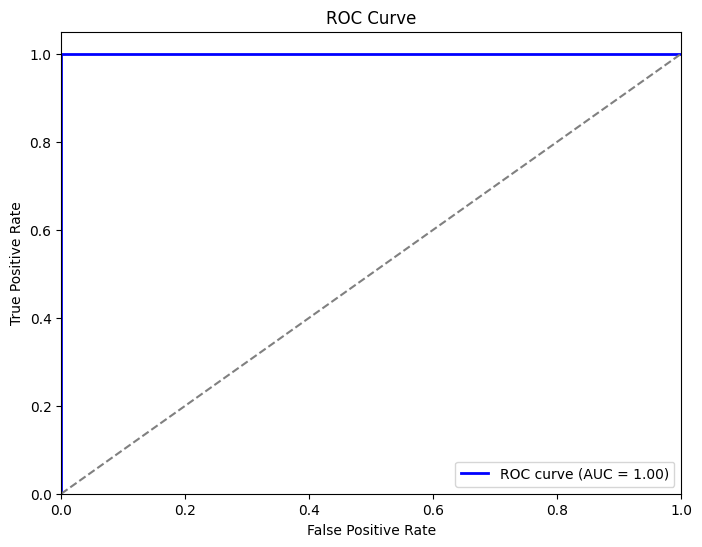

In [13]:
from sklearn.metrics import roc_curve, auc

# Calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 3. Plotting Chart for Top 10 Imporant Features

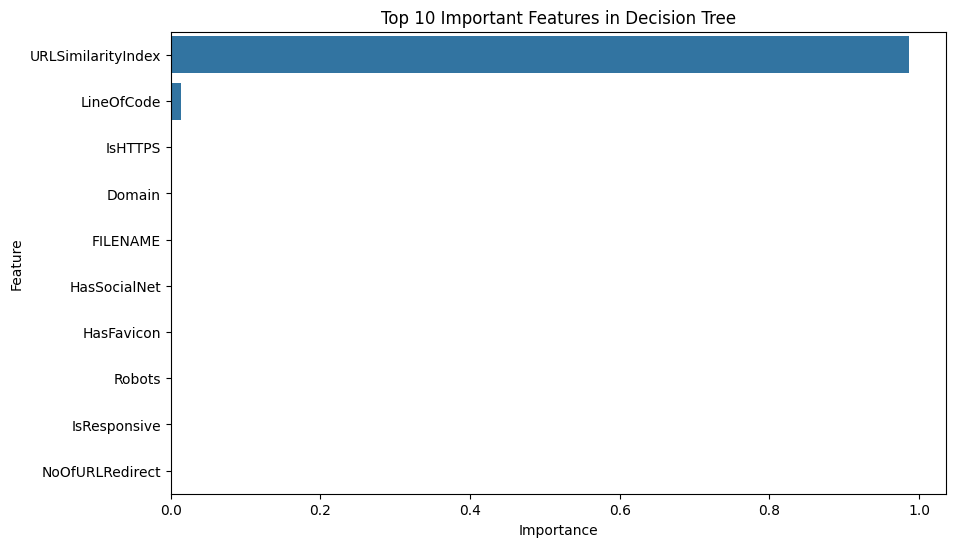

In [14]:
# Get feature importances from the best Decision Tree model
importances = best_model.feature_importances_

# Create a dataframe to display features and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features in Decision Tree')
plt.show()

### 4. Plotting the Decision Tree

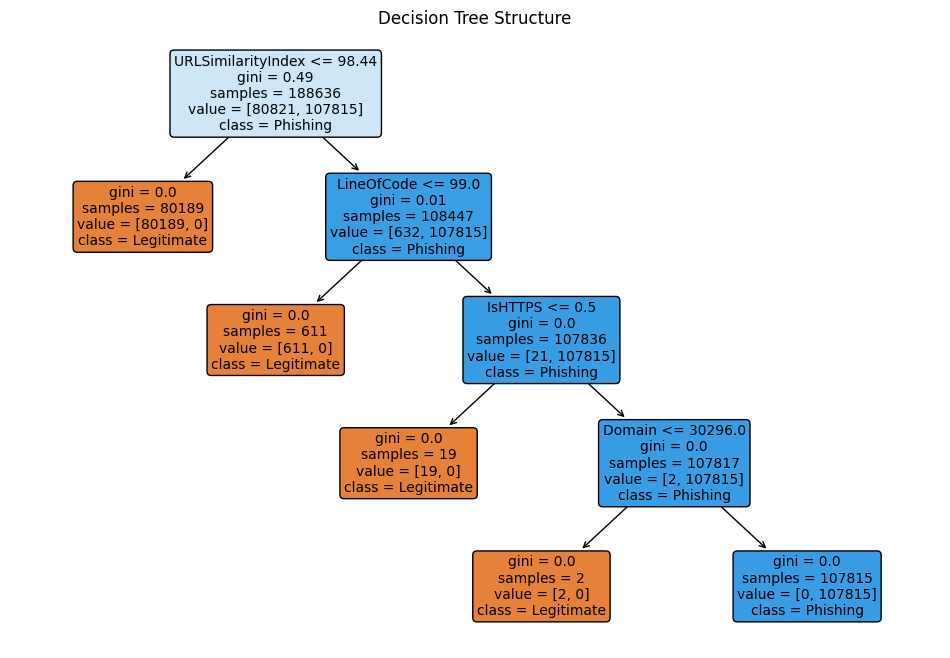

In [15]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['Legitimate', 'Phishing'], 
          rounded=True, proportion=False, precision=2, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d16dae6-23a0-4de8-8dec-da0f0eb28c7f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>